In [85]:
import json
import os
import boto3
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib inline

In [86]:
BUCKET_NAME = 'modin-jenkins-result'

In [87]:
# Connect to s3
s3 = boto3.resource('s3')
client = boto3.client('s3')

# Get list of folders in Bucket
response = client.list_objects(
    Bucket=BUCKET_NAME,
)

# Filter for folders containing perf data for commits merged into master
# use commented out function eventually, just use this for now:
master_commit_keys = [a['Key'] for a in response['Contents'] if "-perf" in a['Key']]
#master_commit_keys = [a['Key'] for a in response['Contents'] if "-perf-COMMIT" in a['Key']]

In [88]:
# Fetch the Perf Data from S3 Bucket
perf_data = []
for key in master_commit_keys:
    response = client.get_object(
        Bucket=BUCKET_NAME,
        Key=key
    )
    file_str = response['Body'].read()
    # Convert the Data to JSON Object before storing
    file_json = json.loads(file_str)
    perf_data.append(file_json)

In [89]:
def json_parser(data):
    """
    This function parses the a single performance json file.
    Args:
        data: json file corresponding to perf data for one commit

    Returns:
        commit_hash: hash of the commit for this file
        commit_order: order of the commit from earliest to latest
        test_data: parsed performance data for each test run in the suite
    """
    commit_hash = commit_data["commit_info"]["id"]
    #commit_order = commit_data["commit_info"]["commit_number"]
    test_data = {}
    for test in commit_data["benchmarks"]:
        name = test["name"][5:]
        test_data[name] = test["stats"]["mean"]
    #return commit_hash, commit_order, test_data
    return commit_hash, test_data

In [90]:
all_commits_data = {}
commit_orders = {}
i = 0

# Loops through all the Perf Data files and gets the parsed data
for commit_data in perf_data:
    # use commented one later and get rid of the i lines
    # commit_hash, commit_order, data = json_parser(commit_data)
    commit_hash, data = json_parser(commit_data)
    all_commits_data[commit_hash] = data
    commit_orders[i] = commit_hash
    i += 1


In [91]:
def plot_function_perf(data, func_name):
    commits = [commit_orders[i] for i in range(len(commit_orders))]
    perf = [data[commit_hash][func_name] for commit_hash in commits]
    commits = [a[:7] for a in commits]
    plt.plot(commits, perf)
    plt.ylabel('seconds')
    plt.xlabel('commit hash')
    plt.title(func_name + ' performance')
    plt.show()

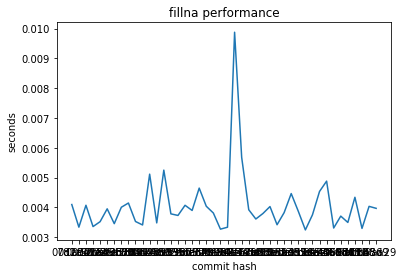

In [92]:
plot_function_perf(all_commits_data, "fillna")

In [ ]:
#Please Ignore Below This Cell

In [2]:
json_dir = os.getcwd() + "/modin/.benchmarks/Darwin-CPython-3.6-64bit/"
master_hash = "ae9f397109620cf00243169654f2f4bec7809b72"

data = []
commit_order = {}
master_data = []
for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        order = int(filename.split("_")[0])
        commit = filename.split("_")[1].split("_")[0]
        if commit == master_hash:
            with open(json_dir + filename) as f:
                master_data.append(json.load(f))
        else:
            commit_order[order] = commit
            with open(json_dir + filename) as f:
                data.append(json.load(f))
            
#commit_order = OrderedDict(sorted(commit_order.items(), key=lambda t: t))
commit_order


{1: 'a368735324669914efcd9020ac3c8ffffab9b641',
 3: '41dbd5e0c89baf4a42aaa50f924e213feda37e6c',
 2: 'e071b337e6162422d9d64e5c9a865cd3ae1f65cc',
 6: 'efe027c9b5a640889c1dc61fd85619dc7c07462a',
 5: '1080060228263b837204c89e5f78ceddd697a448',
 4: 'c6f89afe235a23233267dfbe1f4e0267b1446ea5'}

In [3]:
def json_parser(data):
    parsed_data = {}
    for commit_data in data:
        commit_hash = commit_data["commit_info"]["id"]
        test_data = {}
        for test in commit_data["benchmarks"]:
            name = test["name"][5:]
            test_data[name] = test["stats"]["mean"]
        parsed_data[commit_hash] = test_data
    return parsed_data
        

pprint(json_parser(master_data))
        
    

{'ae9f397109620cf00243169654f2f4bec7809b72': {'add': 0.09603031014557928,
                                              'add_df': 0.031602176127191156,
                                              'describe': 0.11630907212384045,
                                              'fillna': 0.005150823501777674,
                                              'isna': 0.060895159570990426,
                                              'read_csv': 0.0698080029037288,
                                              'sum': 0.10745462782991429}}


In [4]:
def plot_function_perf(other_data, func_name):
    commits = [commit_order[i] for i in range(1,len(commit_order)+1)]
    perf = [other_data[commit_hash][func_name] for commit_hash in commits]
    commits = [a[:7] for a in commits]
    commits = commits[::-1]
    perf = perf[::-1]
    plt.plot(commits, perf)
    plt.ylabel('seconds')
    plt.xlabel('commit hash')
    plt.title(func_name + ' performance')
    plt.show()

def plot_against_master(other_data, master_data, hash_to_compare, func_name):
    #commits = [a for a in commit_order]
    #perf = [other_data[commit_hash][func_name] for commit_hash in commits]
    #commits = [a[:7] for a in commits]
    #commits = commits[::-1]
    #perf = perf[::-1]
    commits = [hash_to_compare[:7], "master"]
    compare_perf = other_data[hash_to_compare][func_name]
    master_perf = master_data[master_hash][func_name]
    perf = [compare_perf, master_perf]
    #x = ["master"]
    #x.append(commits[0])
    #y = [master_data[master_hash][func_name]]
    #y.append(perf[0])
    print(commits)
    print(perf)
    plt.plot(commits, perf)
    plt.ylabel('seconds')
    plt.xlabel('commit hash')
    plt.title(func_name + ' performance')
    plt.show()

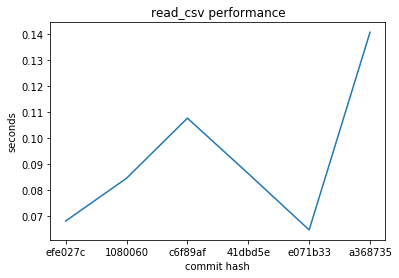

In [5]:
#RUN
other = json_parser(data)
plot_function_perf(other, 'read_csv')

['a368735', 'master']
[0.14083585953339933, 0.0698080029037288]


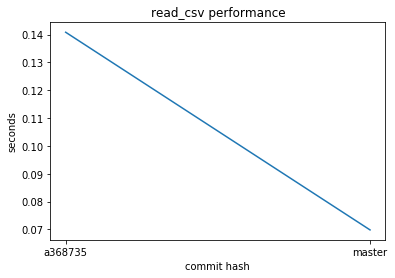

In [6]:
hash_to_compare = 'a368735324669914efcd9020ac3c8ffffab9b641'
master = json_parser(master_data)
plot_against_master(other, master, hash_to_compare, 'read_csv')